In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import YouTubeVideo
from scipy.stats import norm

# Multidimensional Kalman Filter

## for a Constant Acceleration Model (CA)

Situation covered: You have a Position Sensor (e.g. a Vision System) and try to calculate velocity ($\dot x$ and $\dot y$) as well as position ($x$ and $y$) of a ball in 3D space.

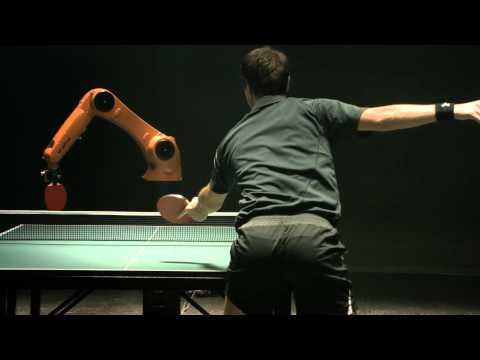

In [8]:
YouTubeVideo("tIIJME8-au8")

## State Vector - Constant Acceleration

Constant Acceleration Model for Motion in 3D

$$x= \left[ \matrix{ x \\ y \\ z \\ \dot x \\ \dot y \\ \dot z \\ \ddot x \\ \ddot y \\ \ddot z} \right]$$



Formal Definition:

$$x_{k+1} = A \cdot x_{k} + B \cdot u_k$$

Hence, we have no control input $u$.

$$x_{k+1} = \begin{bmatrix}1 & 0 & 0 & \Delta t & 0 & 0 & \frac{1}{2}\Delta t^2 & 0 & 0 \\ 0 & 1 & 0 & 0 & \Delta t & 0 & 0 & \frac{1}{2}\Delta t^2 & 0 \\ 0 & 0 & 1 & 0 & 0 & \Delta t & 0 & 0 & \frac{1}{2}\Delta t^2 \\ 0 & 0 & 0 & 1 & 0 & 0 & \Delta t & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & \Delta t & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & \Delta t \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ z \\ \dot x \\ \dot y \\ \dot z \\ \ddot x \\ \ddot y \\ \ddot z\end{bmatrix}_{k}$$

$$y = H \cdot x$$

Position ($x$ & $y$ & $z$) is measured with vision system:

$$y = \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} \cdot x$$

#### Initial Uncertainty

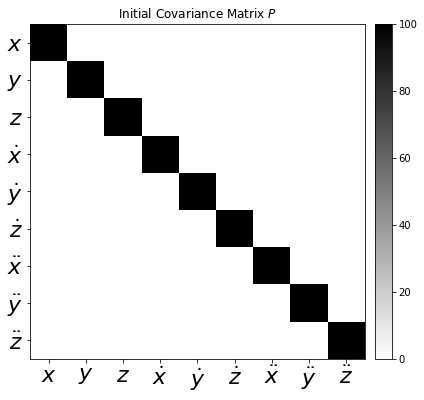

In [9]:
P = 100.0*np.eye(9)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(10))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

plt.xlim([-0.5,8.5])
plt.ylim([8.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Dynamic Matrix

In [10]:
dt = 0.01 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(A.shape)

(9, 9)


## Measurement Matrix

Here you can determine, which of the states is covered by a measurement. In this example, the position ($x$ and $y$) is measured.

In [11]:
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
print(H, H.shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]] (3, 9)


## Measurement Noise Covariance Matrix $R$

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] (3, 3)


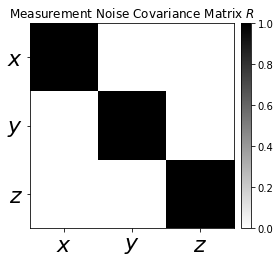

In [12]:
rp = 1.0**2  # Noise of Position Measurement
R = np.matrix([[rp, 0.0, 0.0],
               [0.0, rp, 0.0],
               [0.0, 0.0, rp]])
print(R, R.shape)

fig = plt.figure(figsize=(4, 4))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(4))
# set the locations and labels of the yticks
plt.yticks(np.arange(3),('$x$', '$y$', '$z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(4))
# set the locations and labels of the yticks
plt.xticks(np.arange(3),('$x$', '$y$', '$z$'), fontsize=22)

plt.xlim([-0.5,2.5])
plt.ylim([2.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

## Process Noise Covariance Matrix $Q$ for CA Model

The Position of an object can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

To easily calcualte Q, one can ask the question: How the noise effects my state vector? For example, how the jerk change the position over one timestep dt. With $\sigma_{j}$ as the magnitude of the standard deviation of the jerk, which distrubs the ball in 3D space. We do not assume cross correlation, which means if a jerk will act in x direction of the movement, it will not push in y or z direction.

We can construct the values with the help of a matrix $G$, which is an "actor" to the state vector.

#### Symbolic Calculation

In [13]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('\Delta t')

In [14]:
Gs = Matrix([dts**3/6, dts**2/2, dts])
Gs

⎡        3⎤
⎢\Delta t ⎥
⎢─────────⎥
⎢    6    ⎥
⎢         ⎥
⎢        2⎥
⎢\Delta t ⎥
⎢─────────⎥
⎢    2    ⎥
⎢         ⎥
⎣\Delta t ⎦

In [15]:
Gs*Gs.T

⎡        6          5          4⎤
⎢\Delta t   \Delta t   \Delta t ⎥
⎢─────────  ─────────  ─────────⎥
⎢    36         12         6    ⎥
⎢                               ⎥
⎢        5          4          3⎥
⎢\Delta t   \Delta t   \Delta t ⎥
⎢─────────  ─────────  ─────────⎥
⎢    12         4          2    ⎥
⎢                               ⎥
⎢        4          3           ⎥
⎢\Delta t   \Delta t           2⎥
⎢─────────  ─────────  \Delta t ⎥
⎣    6          2               ⎦

In [16]:
sj = 0.1

Q = np.matrix([[(dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6, 0, 0],
               [0, (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6, 0],
               [0, 0, (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6],
               [(dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2, 0, 0],
               [0, (dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2, 0],
               [0, 0, (dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2],
               [(dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2), 0, 0],
               [0, (dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2), 0],
               [0, 0, (dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2)]]) *sj**2

print(Q.shape)

(9, 9)


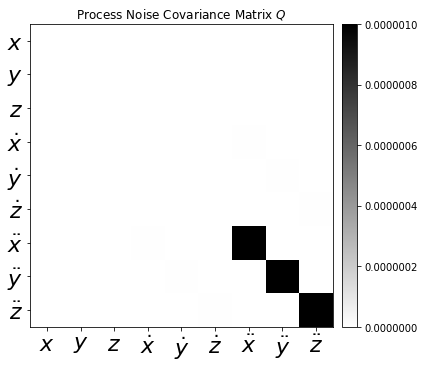

In [17]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(10))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

plt.xlim([-0.5,8.5])
plt.ylim([8.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Disturbance Control Matrix $B$

In [18]:
B = np.matrix([[0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0]])
print(B, B.shape)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] (9, 1)


## Control Input $u$

Assumed constant over time

In [19]:
u = 0.0

## Identity Matrix

In [20]:
I = np.eye(9)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]] (9, 9)


## Measurements

Synthetically creation of the Position Data for the ball

In [21]:
Hz = 100.0 # Frequency of Vision System
dt = 1.0/Hz
T = 1.0 # s measuremnt time
m = int(T/dt) # number of measurements

px= 0.0 # x Position Start
py= 0.0 # y Position Start
pz= 1.0 # z Position Start

vx = 10.0 # m/s Velocity at the beginning
vy = 0.0 # m/s Velocity
vz = 0.0 # m/s Velocity

c = 0.1 # Drag Resistance Coefficient
d = 0.9 # Damping

Xr=[]
Yr=[]
Zr=[]
for i in range(int(m)):
    accx = -c*vx**2  # Drag Resistance
    
    vx += accx*dt
    px += vx*dt

    accz = -9.806 + c*vz**2 # Gravitation + Drag
    vz += accz*dt
    pz += vz*dt
    
    if pz<0.01:
        vz=-vz*d
        pz+=0.02
    if vx<0.1:
        accx=0.0
        accz=0.0
        
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)

### Add Noise to the Real Position

In [22]:
sp= 0.1 # Sigma for position noise

Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

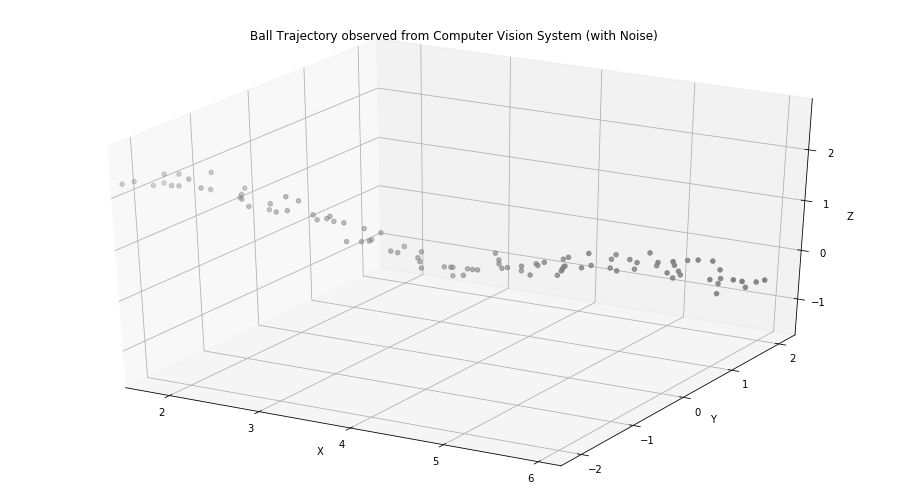

In [23]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm, Ym, Zm, c='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Ball Trajectory observed from Computer Vision System (with Noise)')

#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
#plt.savefig('BallTrajectory-Computervision.png', dpi=150, bbox_inches='tight')

In [24]:
measurements = np.vstack((Xm,Ym,Zm))
print(measurements.shape)

(3, 100)


#### Initial State

In [25]:
x = np.matrix([0.0, 0.0, 1.0, 10.0, 0.0, 0.0, 0.0, 0.0, -9.81]).T
print(x, x.shape)

[[ 0.  ]
 [ 0.  ]
 [ 1.  ]
 [10.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [-9.81]] (9, 1)


In [26]:
# Preallocation for Plotting
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
ddxt=[]
ddyt=[]
ddzt=[]
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Pddx=[]
Pddy=[]
Pddz=[]
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []
Kddx=[]
Kddy=[]
Kddz=[]

## Kalman Filter

![Kalman Filter](Kalman-Filter-Step.png)

In [27]:
hitplate=False
for filterstep in range(m):
    
    # Model the direction switch, when hitting the plate
    if x[2]<0.01 and not hitplate:
        x[5]=-x[5]
        hitplate=True
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x + B*u
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,filterstep].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
   
    
    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    ddxt.append(float(x[6]))
    ddyt.append(float(x[7]))
    ddzt.append(float(x[8]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdz.append(float(P[5,5]))
    Pddx.append(float(P[6,6]))
    Pddy.append(float(P[7,7]))
    Pddz.append(float(P[8,8]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdz.append(float(K[5,0]))
    Kddx.append(float(K[6,0]))
    Kddy.append(float(K[7,0]))
    Kddz.append(float(K[8,0]))

# Plots

## Estimated State

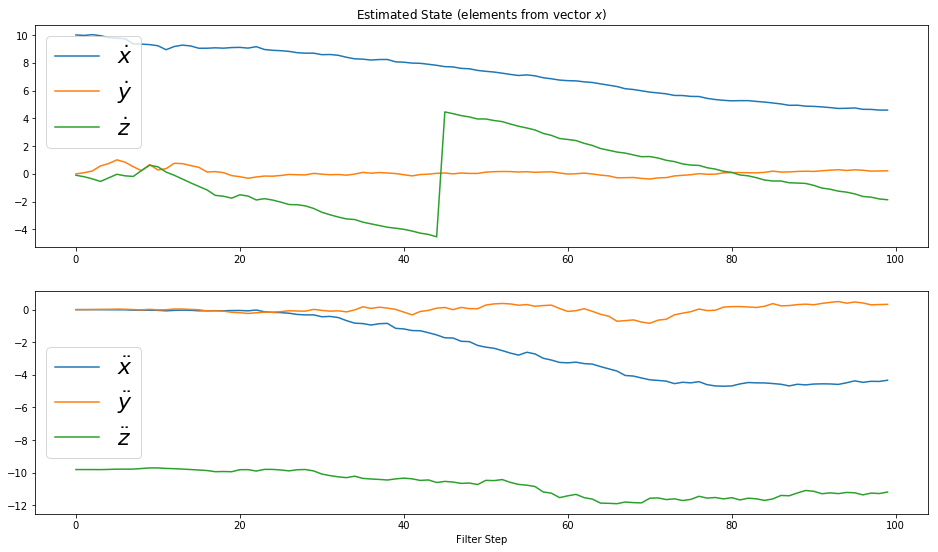

In [28]:
fig = plt.figure(figsize=(16,9))
plt.subplot(211)
plt.title('Estimated State (elements from vector $x$)')
plt.plot(range(len(measurements[0])),dxt, label='$\dot x$')
plt.plot(range(len(measurements[0])),dyt, label='$\dot y$')
plt.plot(range(len(measurements[0])),dzt, label='$\dot z$')
plt.legend(loc='best',prop={'size':22})

plt.subplot(212)
plt.plot(range(len(measurements[0])),ddxt, label='$\ddot x$')
plt.plot(range(len(measurements[0])),ddyt, label='$\ddot y$')
plt.plot(range(len(measurements[0])),ddzt, label='$\ddot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})

### Uncertainty

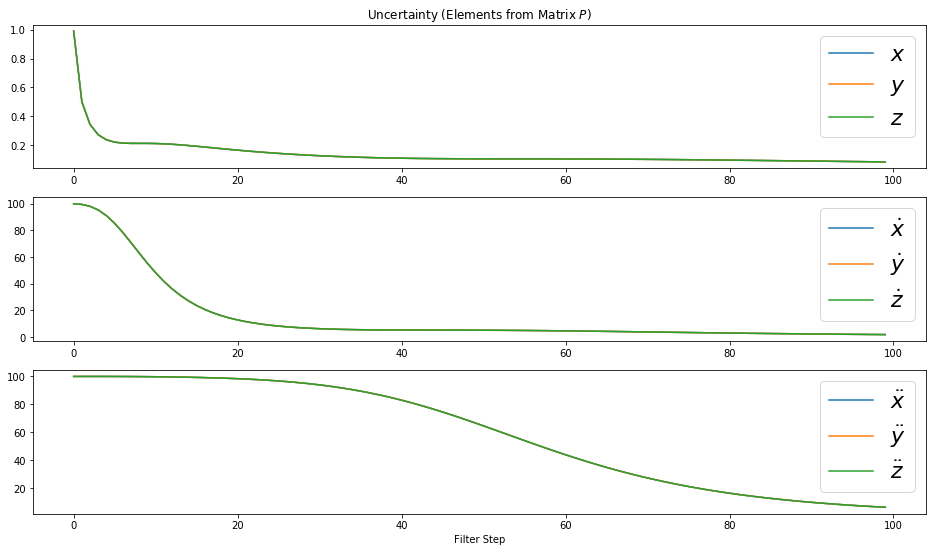

In [29]:
fig = plt.figure(figsize=(16,9))
plt.subplot(311)
plt.plot(range(len(measurements[0])),Px, label='$x$')
plt.plot(range(len(measurements[0])),Py, label='$y$')
plt.plot(range(len(measurements[0])),Pz, label='$z$')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})
plt.subplot(312)
plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')
plt.plot(range(len(measurements[0])),Pdz, label='$\dot z$')
plt.legend(loc='best',prop={'size':22})

plt.subplot(313)
plt.plot(range(len(measurements[0])),Pddx, label='$\ddot x$')
plt.plot(range(len(measurements[0])),Pddy, label='$\ddot y$')
plt.plot(range(len(measurements[0])),Pddz, label='$\ddot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})

### Kalman Gains

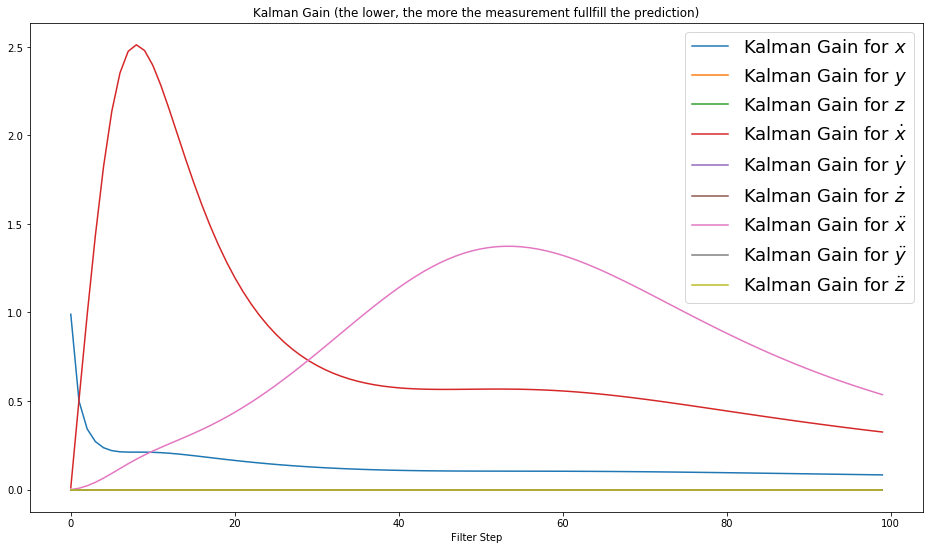

In [30]:
fig = plt.figure(figsize=(16,9))
plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
plt.plot(range(len(measurements[0])),Kz, label='Kalman Gain for $z$')
plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')
plt.plot(range(len(measurements[0])),Kdz, label='Kalman Gain for $\dot z$')
plt.plot(range(len(measurements[0])),Kddx, label='Kalman Gain for $\ddot x$')
plt.plot(range(len(measurements[0])),Kddy, label='Kalman Gain for $\ddot y$')
plt.plot(range(len(measurements[0])),Kddz, label='Kalman Gain for $\ddot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(loc='best',prop={'size':18})

### Covariance Matrix

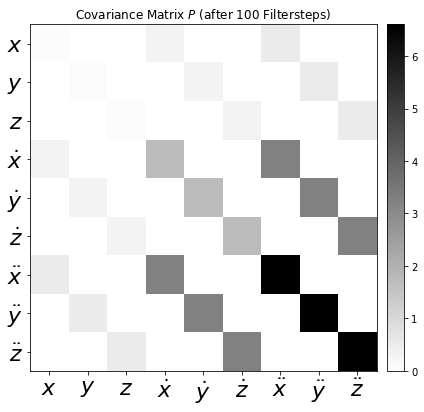

In [31]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filtersteps)' % m)
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(10))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

plt.xlim([-0.5,8.5])
plt.ylim([8.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Position in x/z Plane

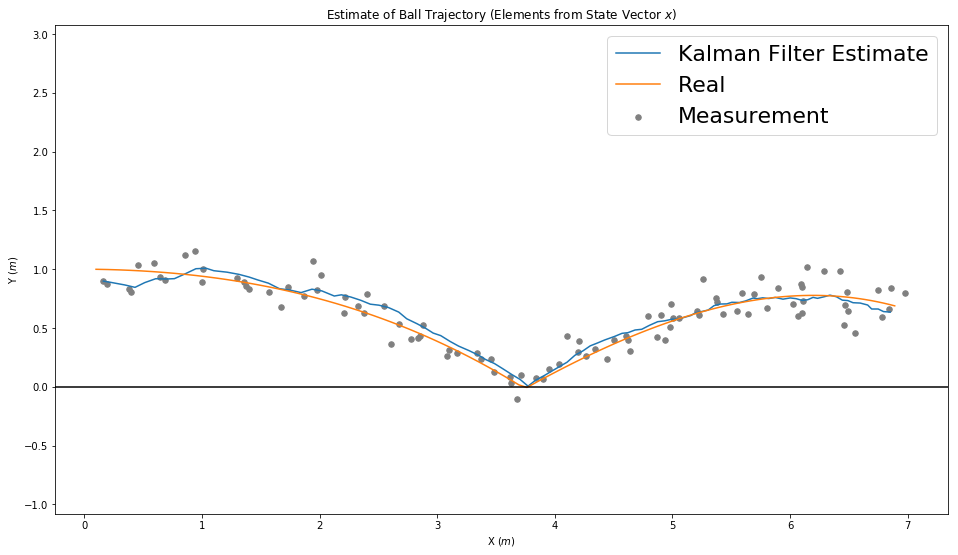

In [32]:
fig = plt.figure(figsize=(16,9))

plt.plot(xt,zt, label='Kalman Filter Estimate')
plt.scatter(Xm,Zm, label='Measurement', c='gray', s=30)
plt.plot(Xr, Zr, label='Real')
plt.title('Estimate of Ball Trajectory (Elements from State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('X ($m$)')
plt.ylabel('Y ($m$)')
plt.ylim(0, 2);
plt.savefig('Kalman-Filter-CA-Ball-StateEstimated.png', dpi=150, bbox_inches='tight')

## Position in 3D

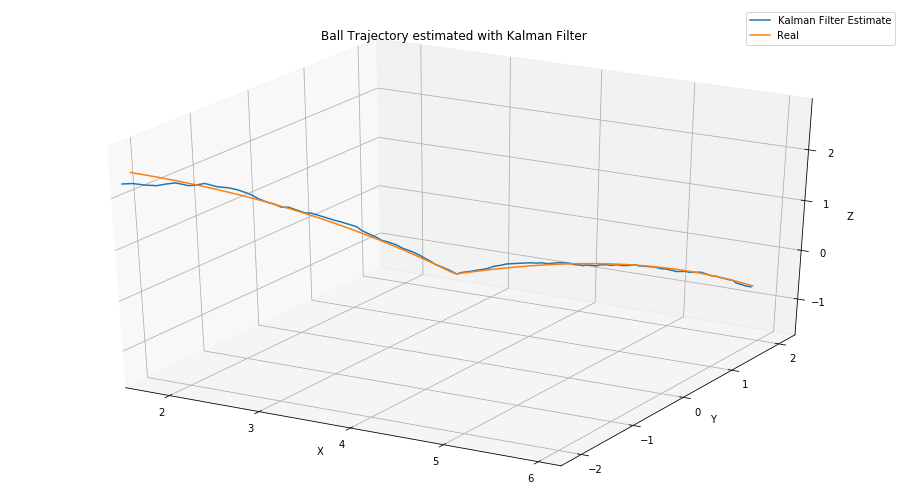

In [33]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt,yt,zt, label='Kalman Filter Estimate')
ax.plot(Xr, Yr, Zr, label='Real')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Ball Trajectory estimated with Kalman Filter')

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
plt.savefig('Kalman-Filter-CA-Ball-Trajectory.png', dpi=150, bbox_inches='tight')

# Conclusion

In [34]:
dist = np.sqrt((Xm-xt)**2 + (Ym-yt)**2 + (Zm-zt)**2)
print('Estimated Position is %.2fm away from ball position.' % dist[-1])

Estimated Position is 0.20m away from ball position.


The Kalman Filter is just for linear dynamic systems. The drag resistance coefficient is nonlinear with a state, but the filter can handle this until a certain amount of drag.

But at this time the ball is hitting the ground, the nonlinearity is too much and the filter is providing a wrong solution. Therefore, one have to model a switch in the filter loop, which helps the filter to get it.

Fragen? [@Balzer82](https://twitter.com/balzer82)